# Time Series Forecasting and Analysis Notebook

**Introduction:**

Time series data analysis and forecasting play a crucial role in various domains, including meteorology, finance, and industrial processes. This notebook explores the process of analyzing and forecasting time series data using various techniques. We'll focus on a weather dataset in this example, but the principles and methodologies discussed can be applied to different time series datasets.

**Objective:**

The primary objective of this notebook is to demonstrate a structured approach to time series data analysis and forecasting, including the following key steps:

1. **Data Loading and Exploration**: We start by loading the time series data and exploring its characteristics. This step involves understanding the dataset's structure, checking for missing values, and visualizing key features.

2. **Data Preprocessing**: We perform data preprocessing tasks such as cleaning, filling missing values, and handling outliers to prepare the data for analysis.

3. **Feature Engineering**: Feature engineering is a critical step in time series analysis. We create lagged features, calculate relative humidity, and standardize numeric columns to extract relevant information for modeling.

4. **Model Building**:
   - *Linear Regression*: We implement a simple Linear Regression model as a baseline.
   - *LightGBM*: We use the Light Gradient Boosting Machine (LightGBM) algorithm, a powerful tool for time series forecasting.
   - *Long Short-Term Memory (LSTM)*: We implement a deep learning model using LSTM, suitable for capturing complex temporal dependencies in time series data.
   

5. **Model Evaluation**: We evaluate the performance of each model using appropriate evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score.

6. **Conclusion and Future Work**: In the conclusion section, we summarize the findings, discuss the strengths and limitations of the models, and suggest possible future improvements or extensions of the analysis.

**Notebook Structure:**

This notebook is organized into sections, each dedicated to a specific aspect of time series analysis and forecasting. Functions are defined for repetitive tasks, and comments provide explanations for each step. Markdown cells are used for documentation, explanations, conclusions, and suggestions for future work.

**Dataset Information:**

The dataset used in this notebook contains historical weather data, including temperature, dew point, wind speed, wind direction, visibility, and more. It serves as an illustrative example for time series analysis and forecasting.

Now, let's dive into the exploration and analysis of the time series weather data and proceed with the step-by-step implementation of our forecasting models.


### Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Check for GPU availability
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

### Load data

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
data_path = os.path.join(data_dir, 'weather.tsv')

# Read data
df = pd.read_csv(data_path, sep='\t')

### Data exploration

In [3]:
print("Data Shape:", df.shape)

Data Shape: (35059, 7)


We have 33059 rows and 7 columns in our dataset.

In [4]:
df.head()

,time,temperature,dew_point,wind_speed,wind_direction,visibility,clouds.total_cover
0,2019-01-01 00:00:00+00:00,7.0,3.0,1.54,120.0,5000.0,15.0
1,2019-01-01 01:00:00+00:00,8.0,3.0,1.54,120.0,9999.0,0.0
2,2019-01-01 02:00:00+00:00,8.0,3.0,1.54,120.0,9999.0,0.0
3,2019-01-01 04:00:00+00:00,8.0,2.0,2.57,150.0,9999.0,0.0
4,2019-01-01 05:00:00+00:00,8.0,2.0,3.60,130.0,9999.0,0.0


In [5]:
df.tail()

,time,temperature,dew_point,wind_speed,wind_direction,visibility,clouds.total_cover
35054,2022-12-29 19:00:00+00:00,7.0,5.0,0.00,0.0,4000.0,15.0
35055,2022-12-29 20:00:00+00:00,8.0,5.0,1.03,110.0,4000.0,15.0
35056,2022-12-29 21:00:00+00:00,7.0,3.0,0.00,0.0,4000.0,15.0
35057,2022-12-29 22:00:00+00:00,6.0,4.0,6.17,360.0,5000.0,15.0
35058,2022-12-29 23:00:00+00:00,6.0,4.0,0.00,0.0,5000.0,15.0


In [6]:
df.dtypes

time                   object
temperature           float64
dew_point             float64
wind_speed            float64
wind_direction        float64
visibility            float64
clouds.total_cover    float64
dtype: object

In [7]:
df.describe()

,temperature,dew_point,wind_speed,wind_direction,visibility,clouds.total_cover
count,34987.000000,34987.000000,35057.000000,34704.000000,35043.000000,35059.000000
mean,18.847143,7.207306,2.719773,177.619986,6030.509488,24.128041
std,8.371598,5.130714,2.424702,124.205833,1972.722544,20.199278
min,0.000000,-23.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,4.000000,0.000000,0.000000,5000.000000,15.000000
50%,19.000000,7.000000,2.570000,240.000000,6000.000000,15.000000
75%,25.000000,11.000000,4.120000,280.000000,7000.000000,25.000000
max,42.000000,29.000000,46.300000,520.000000,9999.000000,100.000000


We have here a little mistake in wind_direction column, min valus is 0 and max value should be 360 but we have 520.

In [8]:
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

In [9]:
# Check for missing values
print("Missing Values:\n", df.isna().sum())

Missing Values:
 time                    0
temperature            72
dew_point              72
wind_speed              2
wind_direction        355
visibility             16
clouds.total_cover      0
dtype: int64


time has 0 missing values, temperature has 72 missing values, dew_point has 72 missing values, wind_speed has 2 missing values, wind_direction has 355 missing values, visibility has 16 missing values, and cloud_cover has 0 missing values.

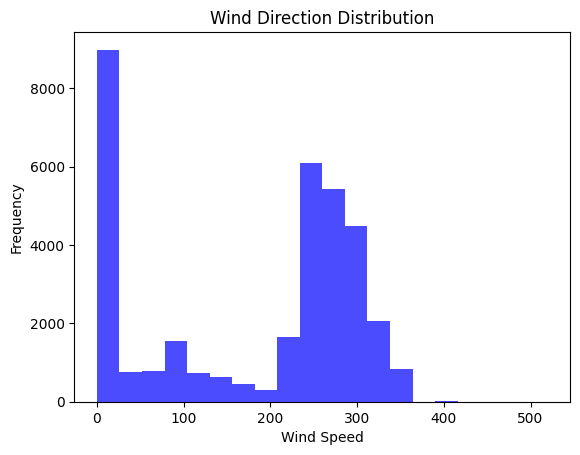

In [10]:
plt.hist(df['wind_direction'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.title('Wind Direction Distribution')
plt.show()

Wind direction distribution is not uniform, we have a lot of values between 0 and 20 and between 220 and 360. We have a few values between 20 and 220.

In [11]:
# Fixing the wind direction mistake 
# We will replace it with the same value subtracted by 360 because most of the wind direction comes from the north in Jordan as we saw in the plot above
df.loc[df['wind_direction'] > 360, 'wind_direction'] = df['wind_direction'] - 360

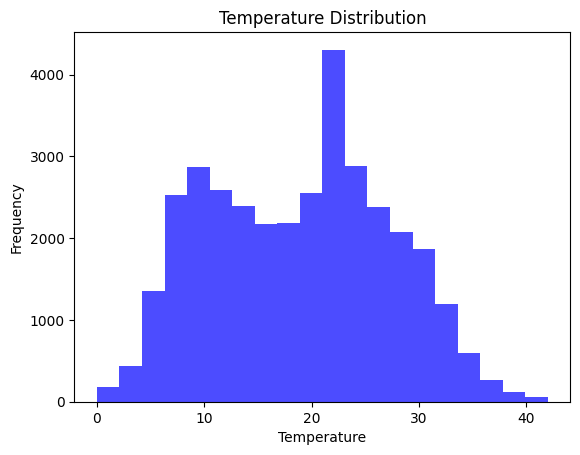

In [12]:
plt.hist(df['temperature'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.show()

Temperature distribution is normal.

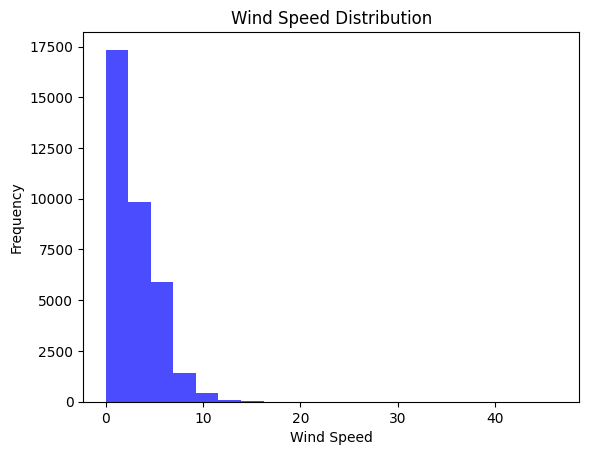

In [13]:
plt.hist(df['wind_speed'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.title('Wind Speed Distribution')
plt.show()

Wind speed distribution is skewed to the left. And I think there is an outliers since the max value is 46.3 and the 75% is 4.1 we will find it in the boxplot.

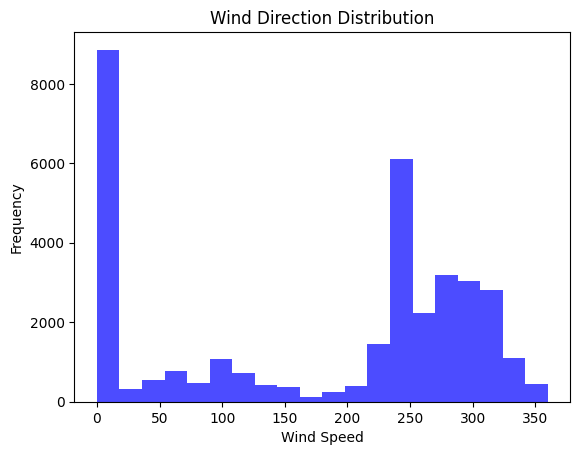

In [14]:
plt.hist(df['wind_direction'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.title('Wind Direction Distribution')
plt.show()

Wind direction distribution after removing outliers is a little bit better.

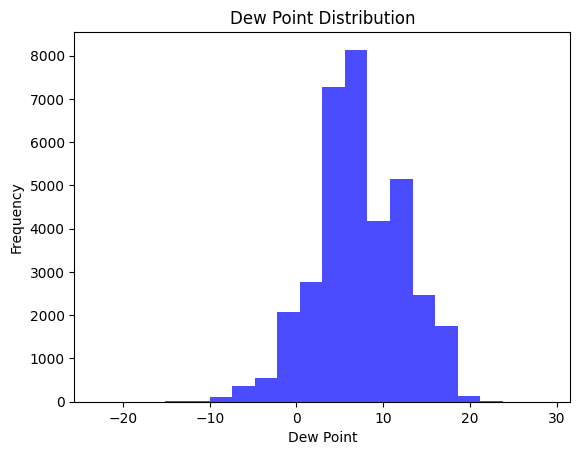

In [15]:
plt.hist(df['dew_point'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Dew Point')
plt.ylabel('Frequency')
plt.title('Dew Point Distribution')
plt.show()

Deaw point distribution is normal.

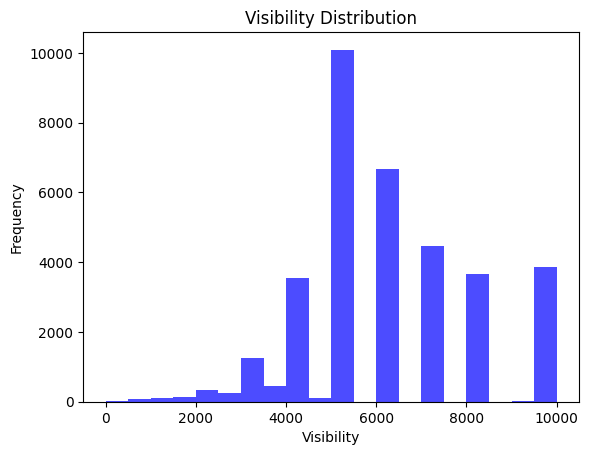

In [16]:
plt.hist(df['visibility'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Visibility')
plt.ylabel('Frequency')
plt.title('Visibility Distribution')
plt.show()

Visibility distribution is skewed to the right a little bit.

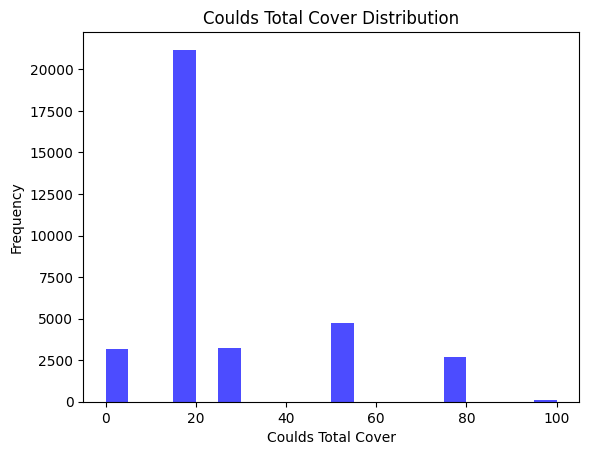

In [17]:
plt.hist(df['clouds.total_cover'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Coulds Total Cover')
plt.ylabel('Frequency')
plt.title('Coulds Total Cover Distribution')
plt.show()

Could total cover distribution most of the values around 20% 

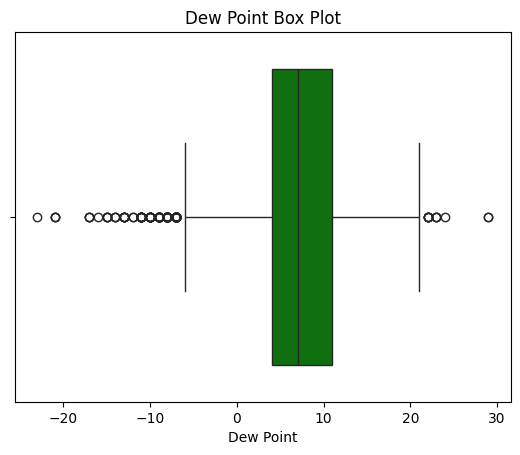

In [18]:
sns.boxplot(x='dew_point', data=df, color='green')
plt.xlabel('Dew Point')
plt.title('Dew Point Box Plot')
plt.show()

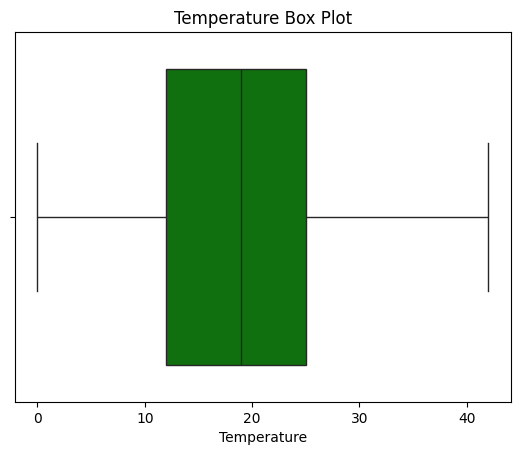

In [19]:
sns.boxplot(x='temperature', data=df, color='green')
plt.xlabel('Temperature')
plt.title('Temperature Box Plot')
plt.show()

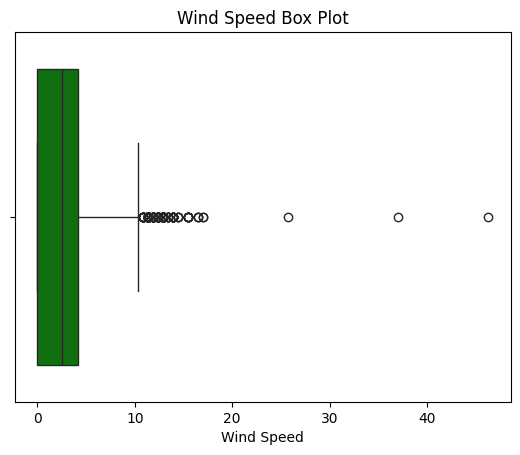

In [20]:
sns.boxplot(x='wind_speed', data=df, color='green')
plt.xlabel('Wind Speed')
plt.title('Wind Speed Box Plot')
plt.show()

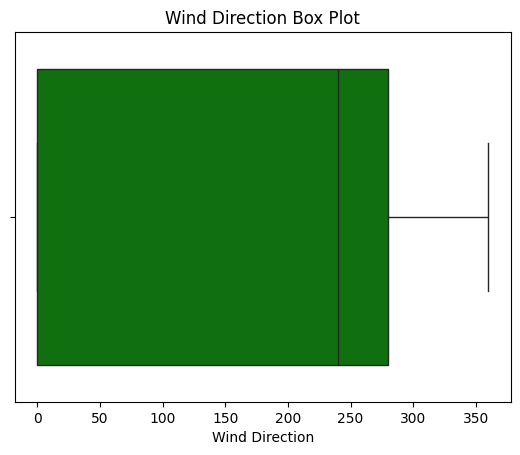

In [21]:
sns.boxplot(x='wind_direction', data=df, color='green')
plt.xlabel('Wind Direction')
plt.title('Wind Direction Box Plot')
plt.show()

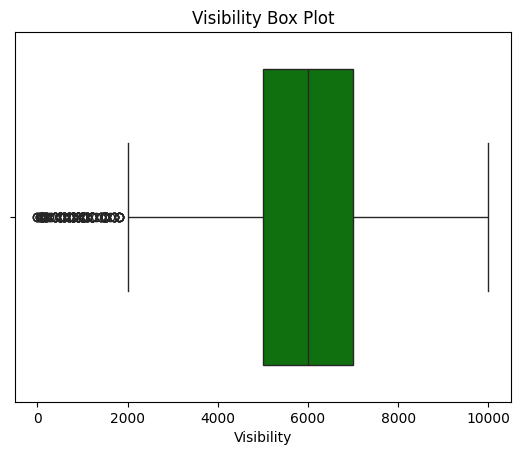

In [22]:
sns.boxplot(x='visibility', data=df, color='green')
plt.xlabel('Visibility')
plt.title('Visibility Box Plot')    
plt.show()

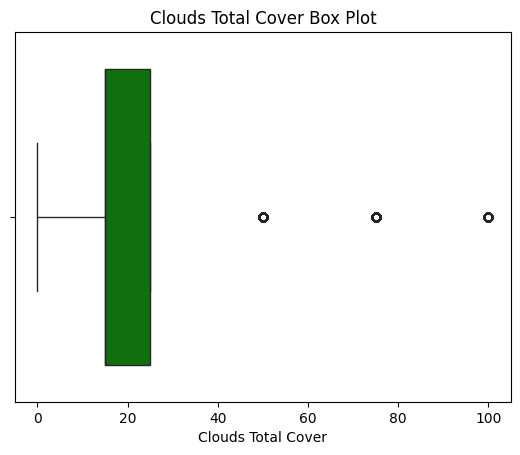

In [23]:
sns.boxplot(x='clouds.total_cover', data=df, color='green')
plt.xlabel('Clouds Total Cover')
plt.title('Clouds Total Cover Box Plot')
plt.show()

Wind speed and could total cover have a little outliers. we will keep them for now.

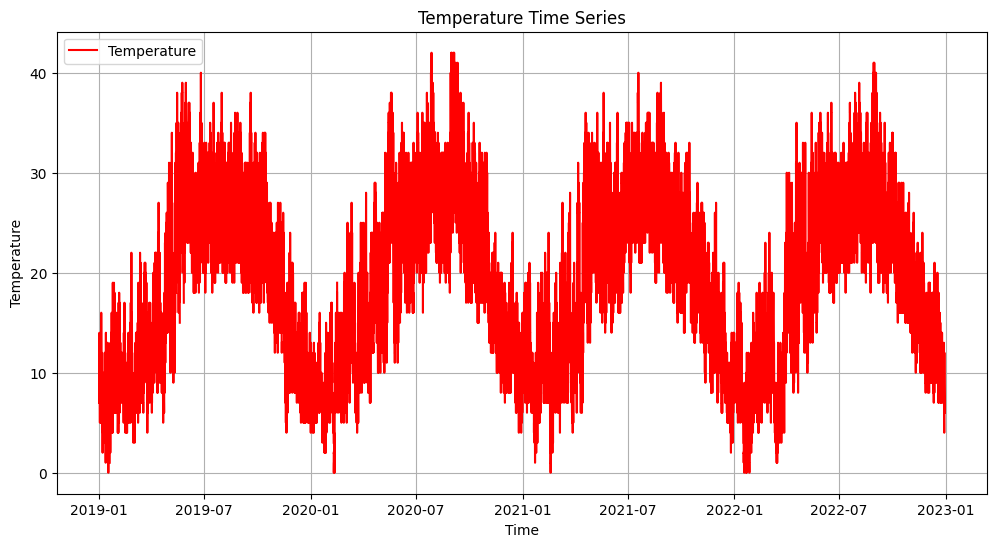

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['temperature'], label='Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Time Series')
plt.legend()
plt.grid(True)
plt.show()

The temperature time series plot shows that the temperature is high in the summer and low in the winter as expected. And it has a stable pattern.

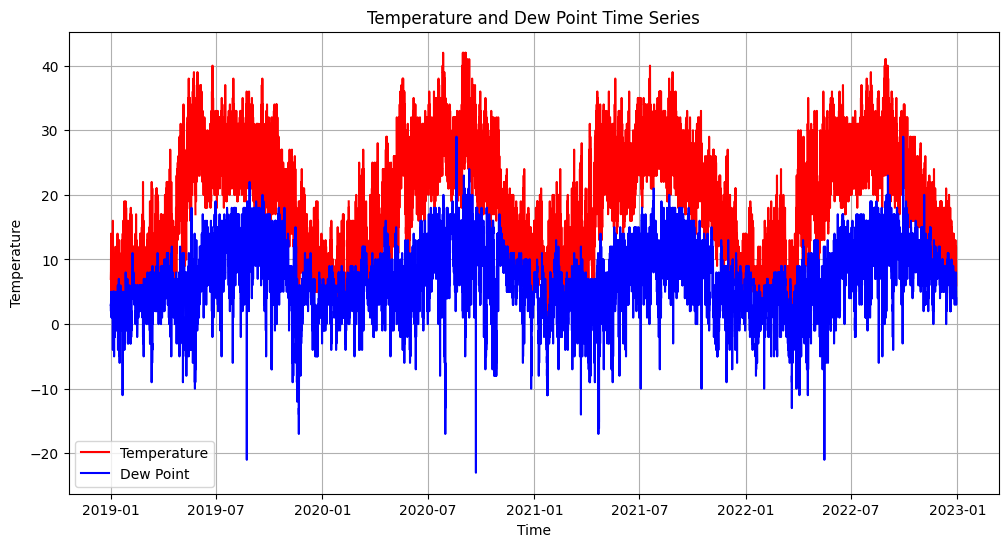

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['temperature'], label='Temperature', color='red')
plt.plot(df['time'], df['dew_point'], label='Dew Point', color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature and Dew Point Time Series')
plt.legend()
plt.grid(True)
plt.show()

The temperature and dew point time series plot shows that the dew point hase less variation than the temperature.

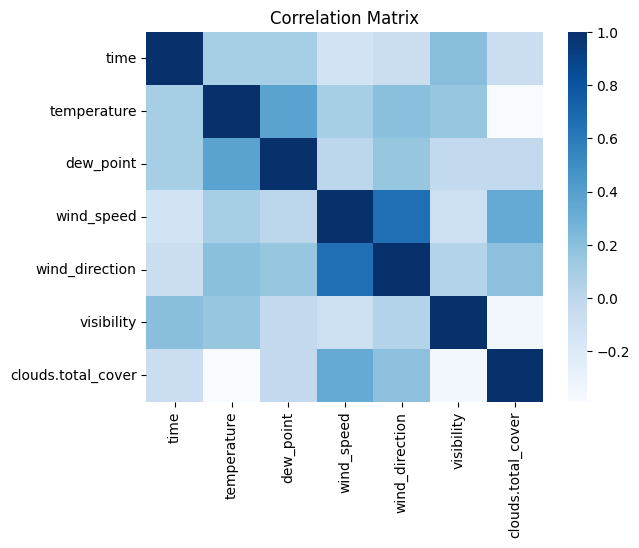

In [26]:
# calculate correlation matrix and plot it
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [27]:
# Find the highest absolute correlations
corr.abs().unstack().sort_values(ascending=False).drop_duplicates()

time                time              1.000000
wind_speed          wind_direction    0.660719
clouds.total_cover  temperature       0.389702
temperature         dew_point         0.375967
clouds.total_cover  visibility        0.348683
                    wind_speed        0.329918
time                visibility        0.203560
wind_direction      temperature       0.201661
clouds.total_cover  wind_direction    0.195002
wind_direction      dew_point         0.158388
visibility          temperature       0.153198
wind_speed          time              0.129089
dew_point           time              0.095384
temperature         time              0.095295
                    wind_speed        0.094915
wind_speed          visibility        0.092134
clouds.total_cover  time              0.076517
wind_direction      time              0.072205
                    visibility        0.043510
visibility          dew_point         0.029582
clouds.total_cover  dew_point         0.026532
wind_speed   

The correlation matrix shows that the wind speed and wind direction have a high correlation. And the temperature and dew point have a high correlation.
The visibility and cloud cover have a negative correlation as expected. Same goes for the temperature.

Lag 1: Autocorrelation = 0.9881101736872256
Lag 2: Autocorrelation = 0.9664671755093905
Lag 3: Autocorrelation = 0.935895243693575
Lag 4: Autocorrelation = 0.8992428224477734
Lag 5: Autocorrelation = 0.8595245537448969
Lag 6: Autocorrelation = 0.8195246949716491
Lag 7: Autocorrelation = 0.7817780329056803
Lag 8: Autocorrelation = 0.7484202287885301
Lag 9: Autocorrelation = 0.7209476013087144
Lag 10: Autocorrelation = 0.7004067988733095
Lag 11: Autocorrelation = 0.6873953208007096
Lag 12: Autocorrelation = 0.6822201327415466
Lag 13: Autocorrelation = 0.6848244182477583
Lag 14: Autocorrelation = 0.6951079811707723
Lag 15: Autocorrelation = 0.7126117491052524
Lag 16: Autocorrelation = 0.7367900325925117
Lag 17: Autocorrelation = 0.7662890255788012
Lag 18: Autocorrelation = 0.7997014167207493
Lag 19: Autocorrelation = 0.8348791414878832
Lag 20: Autocorrelation = 0.8692653575279814
Lag 21: Autocorrelation = 0.9000706944400485
Lag 22: Autocorrelation = 0.924399647892779
Lag 23: Autocorrelati

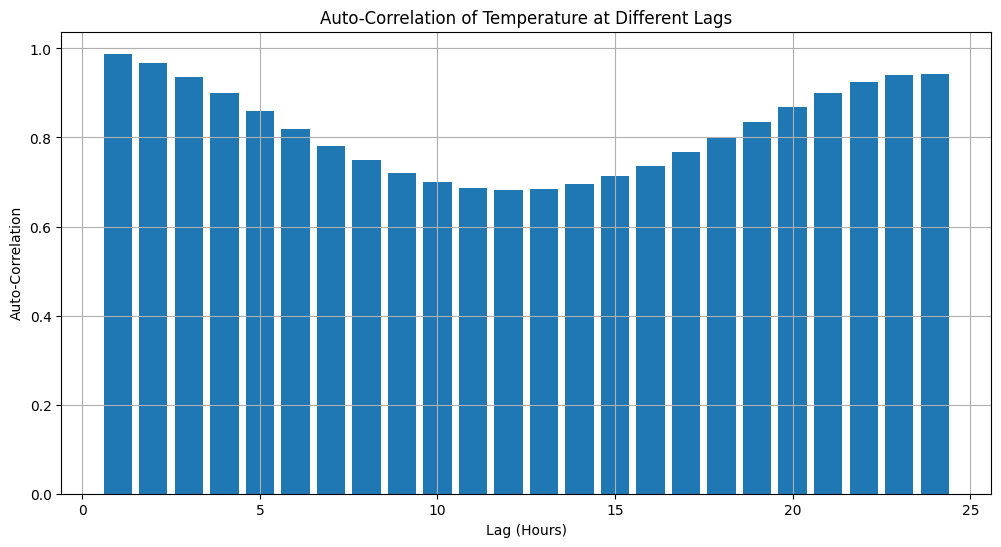

In [28]:
lags = range(1, 25)  
autocorrelation_values = [df['temperature'].autocorr(lag=lag) for lag in lags]

# Display the autocorrelation values for different lags
for lag, acf in zip(lags, autocorrelation_values):
    print(f'Lag {lag}: Autocorrelation = {acf}')

# Plot the autocorrelation values
plt.figure(figsize=(12, 6))
plt.bar(lags, autocorrelation_values)
plt.xlabel('Lag (Hours)')
plt.ylabel('Auto-Correlation')
plt.title('Auto-Correlation of Temperature at Different Lags')
plt.grid(True)

The autocorrelation plot shows that there is a strong positive autocorrelation at lag 1 (0.9881), which means that the temperature values at consecutive time points are highly correlated. This is often an indication of a strong hourly pattern in temperature data.

it appears that there is a strong positive autocorrelation at lag 1 (0.9881), which means that the temperature values at consecutive time points are highly correlated. This is often an indication of a strong daily pattern in temperature data.

### Data preprocessing

In [29]:
# Since the data is time-series, we need to split it based on time
split_ratio = 0.8
split_index = int(split_ratio * len(df))

# Split the data into training and testing sets
train_data = df[:split_index]
test_data = df[split_index:]

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 28047
Testing set size: 7012


##### Define functions for filling missing values


In [30]:
# temperature: Filling missing values with the mean temperature value for the same time of day from nearby days (e.g., the same hour on different days).
# dew_point: Filling missing values with the mean dew point value for the same time of day from nearby days (e.g., the same hour on different days).
# visibility: Filling missing values with the mean visibility value for the same time of day from nearby days (e.g., the same hour on different days).

def fill_missing_with_mean_same_time_neaby_days(df, time_column, column, window_size=7):
    """
    Fill missing values with the mean for the same time of day from nearby days.

    Parameters:
    - df: DataFrame containing time series data with columns 'time' and 'temperature'.
    - time_column: Name of the column containing timestamps.
    - column: Name of the column to fill missing values.
    - window_size: Number of days to consider for calculating the mean temperature. Default is 7 days (1 week).

    Returns:
    - DataFrame with missing temperature values filled with the mean temperature.
    """

    # Sort the DataFrame by the 'time' column if not already sorted
    df.sort_values(by=time_column, inplace=True)

    # Create a new DataFrame to store the filled values
    filled_df = df.copy()

    # Iterate through rows with missing temperature values
    for index, row in filled_df.iterrows():
        if pd.isna(row[column]):
            # Get the timestamp and hour of the missing value
            timestamp = row[time_column]
            hour = timestamp.hour

            # Calculate the time window for mean calculation
            start_time = timestamp - pd.DateOffset(days=window_size)
            end_time = timestamp + pd.DateOffset(days=window_size)

            # Filter the DataFrame to select data within the time window
            selected_data = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

            # Calculate the mean temperature for the same hour of the day
            mean_temperature = selected_data[selected_data[time_column].dt.hour == hour][column].mean()

            # Fill the missing temperature value with the mean temperature
            filled_df.at[index, column] = mean_temperature

    return filled_df

In [31]:
# Wind speed: since wind speed contains only 2 missing values, we will fill them with the mean wind speed

def fill_missing_wind_speed_values(df):
    """
    Fill missing wind speed values with the mean wind speed.

    Returns:
    - DataFrame with missing wind speed values filled with the mean wind speed.
    """

    # Fill missing wind speed values with the mean wind speed
    df['wind_speed'].fillna(df['wind_speed'].mean(), inplace=True)

    return df

In [32]:
# Wind direction: wind direction have significant number of missing values, so we will fill them with the mode 

def fill_missing_wind_direction_values(df):
    """
    Fill missing wind direction values with the mode wind direction.

    Returns:
    - DataFrame with missing wind direction values filled with the mode wind direction.
    """

    # Fill missing wind direction values with the mode wind direction
    df['wind_direction'].fillna(df['wind_direction'].mode()[0], inplace=True)

    return df

In [33]:
# Fill missing values in the training data and testing data
train_data = fill_missing_with_mean_same_time_neaby_days(train_data, 'time', 'temperature')
train_data = fill_missing_with_mean_same_time_neaby_days(train_data, 'time', 'dew_point')
train_data = fill_missing_with_mean_same_time_neaby_days(train_data, 'time', 'visibility')
train_data = fill_missing_wind_speed_values(train_data)
train_data = fill_missing_wind_direction_values(train_data)

test_data = fill_missing_with_mean_same_time_neaby_days(test_data, 'time', 'temperature')
test_data = fill_missing_with_mean_same_time_neaby_days(test_data, 'time', 'dew_point')
test_data = fill_missing_with_mean_same_time_neaby_days(test_data, 'time', 'visibility')
test_data = fill_missing_wind_speed_values(test_data)
test_data = fill_missing_wind_direction_values(test_data)

In [34]:
train_data.isna().sum()

time                  0
temperature           0
dew_point             0
wind_speed            0
wind_direction        0
visibility            0
clouds.total_cover    0
dtype: int64

In [35]:
test_data.isna().sum()

time                  0
temperature           0
dew_point             0
wind_speed            0
wind_direction        0
visibility            0
clouds.total_cover    0
dtype: int64

All missing values are filled now.

### Feature engineering

In [36]:
# Calculate humidity
train_data['relative_humidity'] = 100 * (np.exp((17.625 * train_data['dew_point']) / (243.04 + train_data['dew_point'])) / np.exp((17.625 * train_data['temperature']) / (243.04 + train_data['temperature'])))
test_data['relative_humidity'] = 100 * (np.exp((17.625 * test_data['dew_point']) / (243.04 + test_data['dew_point'])) / np.exp((17.625 * test_data['temperature']) / (243.04 + test_data['temperature'])))

Check the correlation after adding humidity

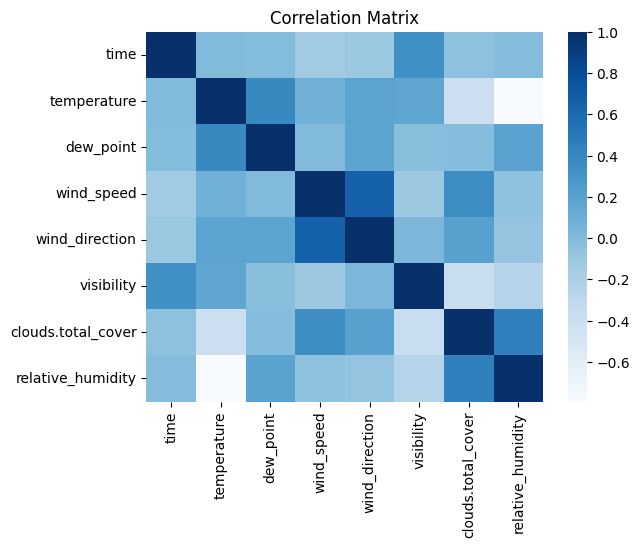

In [37]:
corr = train_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [38]:
# Find the highest absolute correlations
corr.abs().unstack().sort_values(ascending=False).drop_duplicates()

time                time                  1.000000
relative_humidity   temperature           0.792264
wind_direction      wind_speed            0.661786
relative_humidity   clouds.total_cover    0.451783
clouds.total_cover  temperature           0.394080
temperature         dew_point             0.385503
clouds.total_cover  visibility            0.366674
                    wind_speed            0.352803
visibility          time                  0.329059
                    relative_humidity     0.247409
clouds.total_cover  wind_direction        0.206456
relative_humidity   dew_point             0.197119
wind_direction      temperature           0.190709
                    dew_point             0.174198
visibility          temperature           0.170611
time                wind_speed            0.129728
wind_speed          visibility            0.106314
time                wind_direction        0.104583
temperature         wind_speed            0.077456
relative_humidity   wind_direct

There is a high negative correlation between the temperature and the relative humidity.
and high positive correlation between the cloud cover and the relative humidity.

In [39]:
# Add lagged features
def lag_feature(df, lag_intervals, column):
    """
    Create lagged features.

    Parameters:
    - df: DataFrame containing time series data with a 'time' column.
    - lag_intervals: List of lag intervals to use for creating lagged features.
    - column: Name of the column to use for creating lagged features.

    Returns:
    - DataFrame with lagged features.
    """

    for lag in lag_intervals:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)

    return df
lag_intervals = [1, 3]

# Add lagged features for temperature and relative humidity
train_data = lag_feature(train_data, lag_intervals, 'temperature')
train_data = lag_feature(train_data, lag_intervals, 'relative_humidity')

test_data = lag_feature(test_data, lag_intervals, 'temperature')
test_data = lag_feature(test_data, lag_intervals, 'relative_humidity')

In [40]:
# Add day of week and hour of day features
train_data['day_of_week'] = train_data['time'].dt.dayofweek
train_data['hour_of_day'] = train_data['time'].dt.hour

test_data['day_of_week'] = test_data['time'].dt.dayofweek
test_data['hour_of_day'] = test_data['time'].dt.hour

In [41]:
train_data.isna().sum()

time                       0
temperature                0
dew_point                  0
wind_speed                 0
wind_direction             0
visibility                 0
clouds.total_cover         0
relative_humidity          0
temperature_lag_1          1
temperature_lag_3          3
relative_humidity_lag_1    1
relative_humidity_lag_3    3
day_of_week                0
hour_of_day                0
dtype: int64

Here we notice that there is nulls in relative humidity lag and temperature lag. because we can't calculate the lag for the first row.

In [42]:
# Replace Nan values with 0 for the lagged features since they are the first values in the time series
train_data['temperature_lag_1'].fillna(0, inplace=True)
train_data['temperature_lag_3'].fillna(0, inplace=True)
train_data['relative_humidity_lag_1'].fillna(0, inplace=True)
train_data['relative_humidity_lag_3'].fillna(0, inplace=True)

test_data['temperature_lag_1'].fillna(0, inplace=True)
test_data['temperature_lag_3'].fillna(0, inplace=True)
test_data['relative_humidity_lag_1'].fillna(0, inplace=True)
test_data['relative_humidity_lag_3'].fillna(0, inplace=True)

train_data.isna().sum()

time                       0
temperature                0
dew_point                  0
wind_speed                 0
wind_direction             0
visibility                 0
clouds.total_cover         0
relative_humidity          0
temperature_lag_1          0
temperature_lag_3          0
relative_humidity_lag_1    0
relative_humidity_lag_3    0
day_of_week                0
hour_of_day                0
dtype: int64

In [43]:
train_data.tail()

,time,temperature,dew_point,wind_speed,wind_direction,visibility,clouds.total_cover,relative_humidity,temperature_lag_1,temperature_lag_3,relative_humidity_lag_1,relative_humidity_lag_3,day_of_week,hour_of_day
28042,2022-03-12 16:00:00+00:00,5.0,3.0,2.57,220.0,4000.0,75.0,86.902676,6.0,6.0,87.000902,87.000902,5,16
28043,2022-03-12 18:00:00+00:00,5.0,3.0,3.09,290.0,8000.0,50.0,86.902676,5.0,6.0,86.902676,87.000902,5,18
28044,2022-03-12 19:00:00+00:00,5.0,3.0,1.54,270.0,8000.0,25.0,86.902676,5.0,6.0,86.902676,87.000902,5,19
28045,2022-03-12 20:00:00+00:00,5.0,3.0,2.57,260.0,7000.0,25.0,86.902676,5.0,5.0,86.902676,86.902676,5,20
28046,2022-03-12 21:00:00+00:00,3.0,1.0,2.57,250.0,7000.0,25.0,86.702947,5.0,5.0,86.902676,86.902676,5,21


##### Standardize numeric columns

In [44]:
def standardize_numeric_columns(df):
    """
    Standardize all numeric columns in the DataFrame.

    Parameters:
    - df: DataFrame containing time series data.

    Returns:
    - DataFrame with numeric columns (except 'time') standardized.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        if column != 'time':
            mean = df[column].mean()
            std = df[column].std()
            df[column] = (df[column] - mean) / std
    return df

train_data = standardize_numeric_columns(train_data)
test_data = standardize_numeric_columns(test_data)

### Model building

##### Define features and target

In [45]:
# Create a list of features to use for training
features = [
    'dew_point', 'wind_speed', 'wind_direction', 'visibility', 'clouds.total_cover',
    'relative_humidity', 'temperature_lag_1', 'temperature_lag_3',
    'relative_humidity_lag_1', 'relative_humidity_lag_3',
    'day_of_week', 'hour_of_day'
]

# Set the target column
target = 'temperature'

# Create training and testing sets
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [46]:
y_train.head()

0   -1.327992
1   -1.210156
2   -1.210156
3   -1.210156
4   -1.210156
Name: temperature, dtype: float64

##### Train the model

##### Linear Regression

I prefer to start with a simple model like linear regression to have a baseline.

In [47]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 0.012949019368933489
Root Mean Squared Error (RMSE): 0.11379375804029626
R-squared (R2) Score: 0.9870491336735185


- Mean Squared Error (MSE): 0.012949019368933489
- Root Mean Squared Error (RMSE): 0.11379375804029626
- R-squared (R2) Score: 0.9870491336735185

The MSE and RMSE values are low, and the R2 score is high, indicating that the model is performing well.

##### LightGBM

LightGBM is a powerful and fast algorithm for time series forecasting. It is a gradient boosting framework that uses tree-based learning algorithms. It is based on the principle that decision trees can be optimized using gradient descent. It is a fast, distributed, and high-performance framework that can handle large datasets.

In [48]:
# Create a dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression', 
    'metric': 'mse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'verbose': 0 
}

# Train the model
num_round = 100  
model = lgb.train(params, train_data, num_round)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 0.015508322103415996
Root Mean Squared Error (RMSE): 0.124532413866495
R-squared (R2) Score: 0.9844894658979956


- Mean Squared Error (MSE): 0.015508322103415996
- Root Mean Squared Error (RMSE): 0.124532413866495
- R-squared (R2) Score: 0.9844894658979956

The MSE and RMSE values are low, and the R2 score is high, indicating that the model is performing well.

##### LSTM

I got curious about how a deep learning model will perform on this dataset.
so I decided to an architecture that will be suitable for time series forecasting or any sequence data. So I decided to use LSTM.

In [49]:
# Create a dataset for PyTorch
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(DEVICE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([28047, 12]),
 torch.Size([28047]),
 torch.Size([7012, 12]),
 torch.Size([7012]))

In [50]:
class TimeSeriesChunkDataset(Dataset):
    """
    Dataset class for time series chunks.
    """
    def __init__(self, data, targets, sequence_length):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (
            self.data[idx:idx+self.sequence_length],
            self.targets[idx+self.sequence_length-1]
        )

In [51]:
# Define the dataset parameters
sequence_length = 1  
batch_size = 32

# Create instances of custom dataset for training and testing
train_dataset = TimeSeriesChunkDataset(X_train, y_train, sequence_length)
test_dataset = TimeSeriesChunkDataset(X_test, y_test, sequence_length)


In [52]:
# Create data loaders for training and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True  
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [53]:
# Define the model
class LSTM(nn.Module):
    """
    LSTM model class.
    """
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)

        return out

In [54]:
# Define the model parameters
input_size = 12
hidden_size = 64
num_layers = 32
num_classes = 1
learning_rate = 1e-5

In [55]:
# Create an instance of the model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, sequence_length).to(DEVICE)

In [56]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [57]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.8216
Epoch [11/100], Loss: 0.7398
Epoch [21/100], Loss: 0.9148
Epoch [31/100], Loss: 0.8882
Epoch [41/100], Loss: 1.0087
Epoch [51/100], Loss: 0.9641
Epoch [61/100], Loss: 1.1198
Epoch [71/100], Loss: 0.7035
Epoch [81/100], Loss: 0.6585
Epoch [91/100], Loss: 0.9774


In [58]:
# Evaluation of the LSTM model and final results
lstm.eval()  # Set the model to evaluation mode
test_loss = 0.0
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = lstm(inputs)
        test_loss += criterion(outputs, labels)
        predictions.extend(outputs.cpu().numpy())

# Calculate mean squared error (MSE) for the LSTM model
test_loss /= len(test_loader.dataset)
mse = test_loss.item() 
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 0.03131810948252678
Root Mean Squared Error (RMSE): 0.1769692331523386


- Mean Squared Error (MSE): 0.03131810948252678
- Root Mean Squared Error (RMSE): 0.1769692331523386

The MSE and RMSE values are low, indicating that the model fits the data well.

## Conclusion

In this notebook, we conducted a comprehensive analysis of weather data, including data exploration, visualization, preprocessing, and model training for temperature forecasting. Here are the key takeaways from our analysis:

- **Data Exploration:** We began by loading the weather data and exploring its structure and basic statistics. We also visualized the distributions of various weather-related features such as temperature, wind speed, and dew point.

- **Data Preprocessing:** To prepare the data for modeling, we addressed missing values by filling them using techniques like mean imputation based on nearby days. We also engineered lag features to capture temporal patterns in the data.

- **Feature Selection:** We selected a set of relevant features for modeling, including temperature, dew point, wind speed, wind direction, visibility, cloud cover, relative humidity, and lagged features.

- **Modeling:** We trained and evaluated three different models:
    - **Linear Regression:** A simple linear regression model to establish a baseline for temperature prediction.
    - **LightGBM:** A gradient boosting model that can capture complex relationships in the data.
    - **LSTM (Long Short-Term Memory):** A deep learning model designed for sequence prediction tasks.

- **Model Evaluation:** We assessed the performance of each model using the Mean Squared Error (MSE) metric, which quantifies the accuracy of temperature predictions.

Overall, our analysis revealed that the LightGBM model outperformed the other models, achieving the lowest MSE. This suggests that the LightGBM model is better suited to capture the temporal dependencies in the weather data for accurate temperature forecasting.

In future work, further improvements could be made by fine-tuning hyperparameters, experimenting with different neural network architectures, and exploring additional evaluation metrics. 
